In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("allandclive/chicken-disease-1")

print("Path to dataset files:", path)

100%|██████████| 266M/266M [00:02<00:00, 126MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/allandclive/chicken-disease-1/versions/1


In [ ]:
import os
import shutil

# Define the destination directory
dest_dir = "dataset"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Move all contents from the downloaded directory to the destination
for item in os.listdir(path):
    src_path = os.path.join(path, item)
    dest_path = os.path.join(dest_dir, item)
    shutil.move(src_path, dest_path)
    print(f"Moved: {item}")

print(f"All files have been moved to '{dest_dir}'")

Moved: train_data.csv
Moved: Train
All files have been moved to 'dataset'


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Step 1: Split data
def split_data(data_dir, csv_dir):
    df = pd.read_csv(csv_dir)
    df.columns = ['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, stratify=strat, random_state=123, shuffle=True)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, stratify=strat, random_state=123, shuffle=True)

    return train_df, valid_df, test_df

# Step 2: Create generators with improved augmentation
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    color = 'rgb'

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    valid_test_gen = ImageDataGenerator(rescale=1./255)

    train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='sparse',
                                               color_mode=color, shuffle=True, batch_size=batch_size)

    valid_data = valid_test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                    target_size=img_size, class_mode='sparse',
                                                    color_mode=color, shuffle=False, batch_size=batch_size)

    test_data = valid_test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                   target_size=img_size, class_mode='sparse',
                                                   color_mode=color, shuffle=False, batch_size=batch_size)

    return train_data, valid_data, test_data

# Step 3: Load data
data_dir = '/content/dataset/Train'
csv_dir = '/content/dataset/train_data.csv'
train_df, valid_df, test_df = split_data(data_dir, csv_dir)
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

# Step 4: Define improved model
num_classes = len(train_gen.class_indices)

model = models.Sequential([
    layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()





Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,684 (436.27 KB)

 Trainable params: 110,980 (433.52 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Step 5: Define callbacks
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Step 6: Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=30)
                    #callbacks=[early_stopping, lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 99s 434ms/step - accuracy: 0.6248 - loss: 1.0513 - val_accuracy: 0.3717 - val_loss: 1.2827
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 438ms/step - accuracy: 0.7346 - loss: 0.7093 - val_accuracy: 0.5415 - val_loss: 1.2870
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 84s 417ms/step - accuracy: 0.7831 - loss: 0.5848 - val_accuracy: 0.3804 - val_loss: 3.1475
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 88s 438ms/step - accuracy: 0.8056 - loss: 0.5221 - val_accuracy: 0.6778 - val_loss: 0.9669
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 387ms/step - accuracy: 0.8257 - loss: 0.4890 - val_accuracy: 0.3730 - val_loss: 3.3795
Epoch 6/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 392ms/step - accuracy: 0.8324 - loss: 0.4639 - val_accuracy: 0.6803 - val_loss: 1.0857
Epoch 7/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 80s 394ms/step - accuracy: 0.8415 - loss: 0.4453 - val_accuracy: 0.8005 - val_loss: 0.5984
Epoch 8/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 390ms/step - accuracy: 0.8489 - loss: 0

In [ ]:
# Save the full model including architecture, optimizer, and weights
model.save('chicken_disease_model.h5')

# Optional: Save only the weights
#model.save_weights('chicken_disease_weights.h5')

print("Model aved successfully!")


Model aved successfully!


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

Classification Report:
                     precision    recall  f1-score   support

       Coccidiosis       0.36      0.96      0.52       247
           Healthy       0.46      0.07      0.13       241
New Castle Disease       0.67      0.11      0.18        56
        Salmonella       0.99      0.35      0.51       263

          accuracy                           0.44       807
         macro avg       0.62      0.37      0.34       807
      weighted avg       0.62      0.44      0.38       807



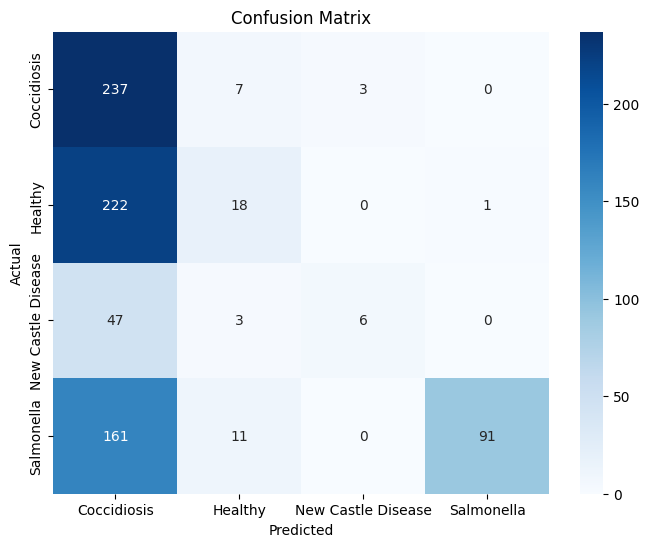

In [ ]:
# Step 7: Evaluation
# Predict on test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Class names
class_names = list(test_gen.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


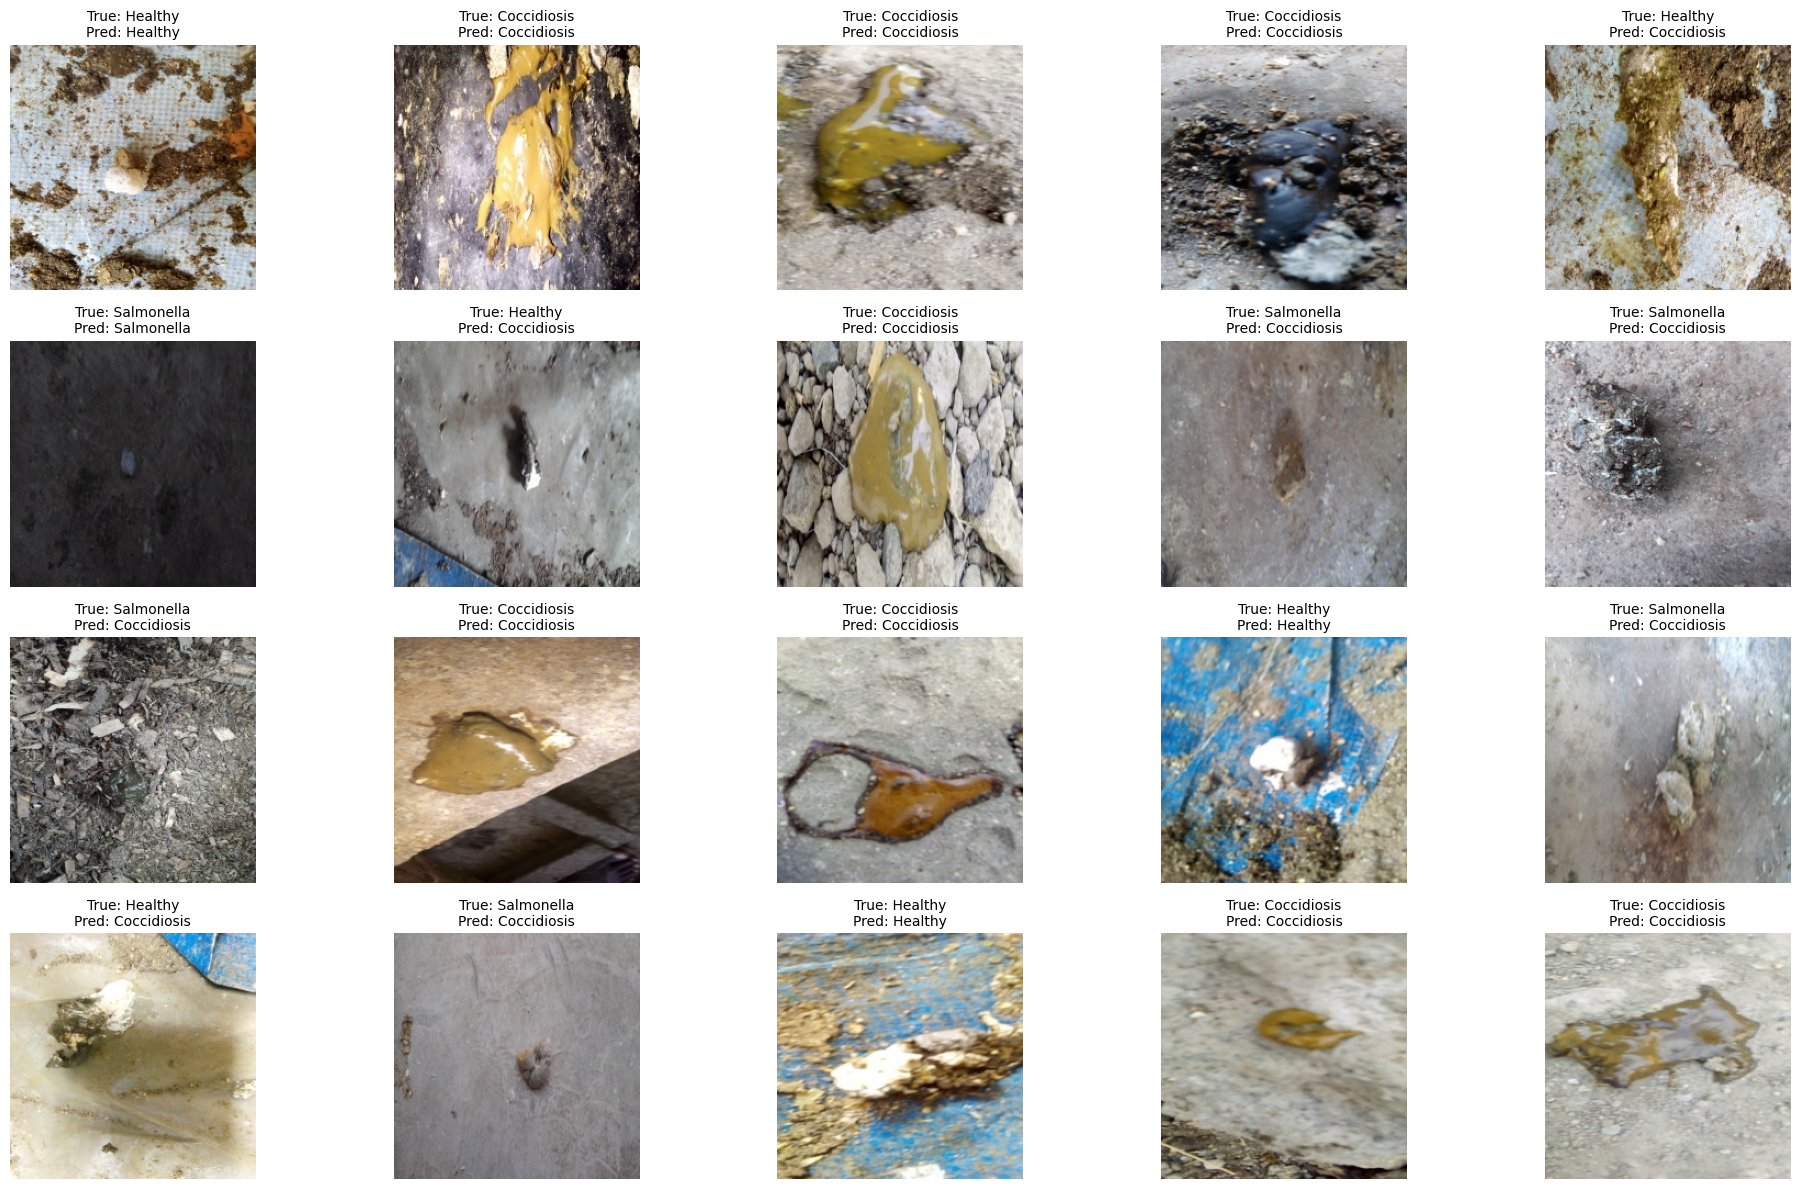

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

# 📌 Define valid class names
class_names = ['Coccidiosis', 'Salmonella', 'Newcastle Disease', 'Healthy']

# 📌 Display 20 random test images
plt.figure(figsize=(20, 12))

for i in range(20):
    # Pick random test image
    idx = random.randint(0, len(test_gen.filenames) - 1)
    img_path = test_gen.filepaths[idx]

    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_exp = np.expand_dims(img_array, axis=0)

    # Prediction
    pred = model.predict(img_exp)
    pred_class = class_names[np.argmax(pred)]

    # True class (from encoded labels)
    true_index = y_true[idx]
    true_class = class_names[true_index] if true_index < len(class_names) else "Unknown"

    # Flag incorrect or unknown true labels
    is_wrong = true_class not in class_names

    # Prepare image for display
    img_to_display = (img_array * 255).astype("uint8")

    # Plot
    plt.subplot(4, 5, i + 1)
    plt.imshow(img_to_display)

    if is_wrong:
        title_text = "❌ Wrong Image"
        print(f"[Warning] Image at index {idx} has an unknown label.")
    else:
        title_text = f"True: {true_class}\nPred: {pred_class}"

    plt.title(title_text, fontsize=10, color='red' if is_wrong else 'black')
    plt.axis('off')

plt.tight_layout()
plt.show()


**Function to Classify Any Image**

In [ ]:
# 📌 2. Define class names (update as per your training order)
class_names = ['Coccidiosis', 'Salmonella', 'Newcastle Disease', 'Healthy']  # Example classes

# 📌 3. Define Classification Function
def classify_chicken_image(model, img_path):
    """
    Classify and display a chicken image using the trained model.

    Parameters:
    - model: Trained Keras model
    - img_path: Path to the input image

    Returns:
    - Predicted class label (string)
    """
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))  # Adjust if needed
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = class_names[predicted_class_index]

        # Display image with label
        plt.imshow(image.load_img(img_path))
        plt.title(f"Predicted: {predicted_class_label}", fontsize=14)
        plt.axis('off')
        plt.show()

        return predicted_class_label

    except Exception as e:
        return f"Error: {str(e)}"

# 📌 4. Load Your Trained Model
model_path = '/content/chicken_disease_model.h5'  # Change path if needed
model = load_model(model_path)

# 📌 5. Classify and Display Result for a Test Image
image_path = '/content/1.jpg'  # Replace with your test image path
result = classify_chicken_image(model, image_path)

print("✅ Prediction:", result)


# Chicken Disease Classification with MobileNetV2

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub


In [4]:
# Download dataset
path = kagglehub.dataset_download("allandclive/chicken-disease-1")
print("Path to dataset files:", path)

# Define destination directory
dest_dir = "dataset"
os.makedirs(dest_dir, exist_ok=True)

# Copy contents to destination, handling files and directories
for item in os.listdir(path):
    src_path = os.path.join(path, item)
    dest_path = os.path.join(dest_dir, item)

    # Check if the item is a file or a directory
    if os.path.isfile(src_path):
        # If it's a file (like the CSV), copy it
        shutil.copy2(src_path, dest_path)
        print(f"Copied file: {item}")
    elif os.path.isdir(src_path):
        # If it's a directory (like 'Train' or 'Test'), copy the entire directory
        # Ensure the destination directory for the subdirectory exists
        os.makedirs(dest_path, exist_ok=True)
        # Use copytree for recursive copying of the directory contents
        shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        print(f"Copied directory: {item}")
    else:
        # Handle other types of items if necessary (e.g., symlinks)
        print(f"Skipping unknown item type: {item}")


print(f"All relevant files and directories have been copied to '{dest_dir}'")

Path to dataset files: /kaggle/input/chicken-disease-1
Copied file: train_data.csv
Copied directory: Train
All relevant files and directories have been copied to 'dataset'


In [6]:
def split_data(data_dir, csv_dir):
    df = pd.read_csv(csv_dir)
    df.columns = ['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))
    train_df, dummy_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=123)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, stratify=dummy_df['labels'], random_state=123)
    return train_df, valid_df, test_df

def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    color = 'rgb'
    train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)
    valid_test_gen = ImageDataGenerator(rescale=1./255)
    train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='sparse',
                                               color_mode=color, shuffle=True, batch_size=batch_size)
    valid_data = valid_test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                    target_size=img_size, class_mode='sparse',
                                                    color_mode=color, shuffle=False, batch_size=batch_size)
    test_data = valid_test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                   target_size=img_size, class_mode='sparse',
                                                   color_mode=color, shuffle=False, batch_size=batch_size)
    return train_data, valid_data, test_data

# Load and prepare data
data_dir = 'dataset/Train'
csv_dir = 'dataset/train_data.csv'
train_df, valid_df, test_df = split_data(data_dir, csv_dir)
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
num_classes = len(train_gen.class_indices)


Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


In [7]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=30)
model.save('mobilenet_chicken_model.h5')
print("Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 109s 473ms/step - accuracy: 0.7213 - loss: 0.7751 - val_accuracy: 0.8476 - val_loss: 0.4404
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 127s 432ms/step - accuracy: 0.8338 - loss: 0.4321 - val_accuracy: 0.8724 - val_loss: 0.3299
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 132s 385ms/step - accuracy: 0.8606 - loss: 0.3828 - val_accuracy: 0.8748 - val_loss: 0.3306
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - accuracy: 0.8660 - loss: 0.3510 - val_accuracy: 0.8798 - val_loss: 0.3068
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 90s 445ms/step - accuracy: 0.8731 - loss: 0.3482 - val_accuracy: 0.8971 - val_loss: 0.2869
Epoch 6/30
 91/202 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.9000 - loss: 0.3012

In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
plt.figure(figsize=(20, 12))
for i in range(20):
    idx = random.randint(0, len(test_gen.filenames) - 1)
    img_path = test_gen.filepaths[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_exp = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_exp)
    pred_class = class_names[np.argmax(pred)]
    true_class = class_names[y_true[idx]]
    plt.subplot(4, 5, i + 1)
    plt.imshow((img_array * 255).astype("uint8"))
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def classify_chicken_image(model, img_path, class_names, confidence_threshold=0.7):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_confidence = np.max(predictions)
        label = "❌ Wrong Image" if predicted_confidence < confidence_threshold else class_names[predicted_class_index]
        plt.imshow(image.load_img(img_path))
        plt.title(f"Predicted: {label} ({predicted_confidence:.2f})")
        plt.axis('off')
        plt.show()
        return label
    except Exception as e:
        return f"Error: {str(e)}"

# Example prediction (update the image path as needed)
model = load_model('mobilenet_chicken_model.h5')
example_image_path = 'dataset/Train/Coccidiosis/2.jpg'  # Replace with your image path
result = classify_chicken_image(model, example_image_path, class_names)
print("✅ Prediction:", result)


# Chicken Disease Classification with EfficientNetB0 (Full Code)

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Download dataset
path = kagglehub.dataset_download("allandclive/chicken-disease-1")
print("Path to dataset files:", path)

# Define destination directory
dest_dir = "dataset"
os.makedirs(dest_dir, exist_ok=True)

# Copy contents to destination, handling files and directories
for item in os.listdir(path):
    src_path = os.path.join(path, item)
    dest_path = os.path.join(dest_dir, item)

    # Check if the item is a file or a directory
    if os.path.isfile(src_path):
        # If it's a file (like the CSV), copy it
        shutil.copy2(src_path, dest_path)
        print(f"Copied file: {item}")
    elif os.path.isdir(src_path):
        # If it's a directory (like 'Train' or 'Test'), copy the entire directory
        # Ensure the destination directory for the subdirectory exists
        os.makedirs(dest_path, exist_ok=True)
        # Use copytree for recursive copying of the directory contents
        shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        print(f"Copied directory: {item}")
    else:
        # Handle other types of items if necessary (e.g., symlinks)
        print(f"Skipping unknown item type: {item}")


print(f"All relevant files and directories have been copied to '{dest_dir}'")

for data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_mobilenet_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)

    # ✅ Data Augmentation for training
    train_aug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # ⚠️ Only rescale for validation/test
    valid_test_aug = ImageDataGenerator(rescale=1./255)

    train_data = train_aug.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, color_mode='rgb',
                                               class_mode='sparse', shuffle=True, batch_size=batch_size)

    valid_data = valid_test_aug.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                    target_size=img_size, color_mode='rgb',
                                                    class_mode='sparse', shuffle=False, batch_size=batch_size)

    test_data = valid_test_aug.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                   target_size=img_size, color_mode='rgb',
                                                   class_mode='sparse', shuffle=False, batch_size=batch_size)

    return train_data, valid_data, test_data


In [ ]:
def split_data(data_dir, csv_file):
    df = pd.read_csv(csv_file)
    df.columns = ['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))
    train_df, dummy_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=123)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, stratify=dummy_df['labels'], random_state=123)
    return train_df, valid_df, test_df

def create_generators(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    color_mode = 'rgb'

    train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)

    valid_test_gen = ImageDataGenerator(rescale=1./255)

    train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, color_mode=color_mode,
                                               class_mode='sparse', shuffle=True, batch_size=batch_size)

    valid_data = valid_test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                    target_size=img_size, color_mode=color_mode,
                                                    class_mode='sparse', shuffle=False, batch_size=batch_size)

    test_data = valid_test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                   target_size=img_size, color_mode=color_mode,
                                                   class_mode='sparse', shuffle=False, batch_size=batch_size)

    return train_data, valid_data, test_data

# Apply the above functions
data_dir = 'dataset/Train'
csv_file = 'dataset/train_data.csv'

train_df, valid_df, test_df = split_data(data_dir, csv_file)
batch_size = 32
train_gen, valid_gen, test_gen = create_generators(train_df, valid_df, test_df, batch_size)
num_classes = len(train_gen.class_indices)


In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=30)
model.save('efficientnet_chicken_model.h5')
print("✅ Model saved as 'efficientnet_chicken_model.h5'")


In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
plt.figure(figsize=(20, 12))
for i in range(20):
    idx = random.randint(0, len(test_gen.filenames) - 1)
    img_path = test_gen.filepaths[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))
    pred_class = class_names[np.argmax(pred)]
    true_class = class_names[y_true[idx]]

    plt.subplot(4, 5, i + 1)
    plt.imshow((img_array * 255).astype("uint8"))
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def classify_chicken_image(model, img_path, class_names, confidence_threshold=0.7):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        confidence = np.max(predictions)
        class_index = np.argmax(predictions)
        label = "❌ Wrong Image" if confidence < confidence_threshold else class_names[class_index]

        plt.imshow(img)
        plt.title(f"Predicted: {label} ({confidence:.2f})")
        plt.axis('off')
        plt.show()
        return label
    except Exception as e:
        return f"Error: {str(e)}"

# Load saved model and test with an example
model = models.load_model('efficientnet_chicken_model.h5')
example_img_path = 'dataset/Train/Coccidiosis/2.jpg'  # Change path as needed
result = classify_chicken_image(model, example_img_path, class_names)
print("Prediction:", result)
